In [17]:
# imports
import numpy as np
import matplotlib.pyplot as plt

In [10]:
class LocalBalancedNetwork:
    def __init__(self, params):
        self.N = params['N']
        self.tdel = params['tdel']
        self.alpha = params['alpha']
        self.F_max = params['F_max']
        self.F_min = params['F_min']
        self.lam = 1 / params['tau']
        self.mu = params['mu']
        self.dt = params['dt']
        
        # Generate weights
        self.D = np.ones((1, self.N))
        self.D[:, :(int(self.N / 2))] = -1  # Balanced positive vs negative weights
        self.D = (self.D / np.linalg.norm(self.D, axis=0) * params['D_mean'] + 
                  np.random.randn(1, self.N) * params['D_noise'])  # Normalize and add noise
        
        # Threshold
        self.threshold = (self.mu / self.lam ** 2 + np.diag(self.D.T @ self.D)) / 2

        # Identity matrix
        self.I = np.identity(self.N)
        
    def run(self, input):
        nT, nd = input.shape  # Extract number of time bins and dimensions of the input
        d_input = np.gradient(input[:, 0]) / self.dt  # Derivative of the input
        
        # Initialize variables
        v = np.zeros((self.N, nT + 1 + self.tdel))  # Voltage
        s = np.zeros((self.N, nT + 1 + self.tdel))  # Spike train
        r = np.zeros((self.N, nT + 1 + self.tdel))  # Filtered spike trains
        prob_spike = np.zeros((self.N, nT + self.tdel))  # Probability of spike

        r[:, 0] = np.linalg.pinv(self.D) @ input[0]
        v[:, 0] = self.D.T @ (input[0] - self.D @ r[:, 0])

        # Run network simulation (Euler method)
        for t in range(nT):
            # Update filtered spike trains
            dr = -self.lam * r[:, t] + s[:, t]
            r[:, t + 1] = r[:, t] + dr * self.dt

            # Update voltage
            W_self = (np.diag(self.D.T @ self.D) + (self.mu / self.lam ** 2)) * self.I
            W_recurrent = self.D.T @ self.D
            np.fill_diagonal(W_recurrent, 0)  # Set self connections to 0
            dv = (-self.lam * v[:, t] + 
                  self.D.T @ (self.lam * input[t] + d_input[t]) - 
                  (W_self @ s[:, t] + W_recurrent @ s[:, t - self.tdel]))  # Only add delay to recurrent connection
            v[:, t + 1] = v[:, t] + dv * self.dt

            # Compute spike rate and probability of spike (in self.dt)
            conditional_intensity = (self.F_max / 
                                     (1 + self.F_max * np.exp(-self.alpha * (v[:, t + 1] - self.threshold))) + 
                                     self.F_min)  # Conditional intensity
            prob_spike[:, t] = 1 - np.exp(-conditional_intensity * self.dt)  # Probability of spike

            # Spiking
            rand = np.random.rand(1, self.N)
            spike = np.where(prob_spike[:, t] > rand[0, :])[0]  # Find neurons that spike
            if len(spike):
                s[spike, t + 1] = 1 / self.dt

        # Get estimate
        estimate = self.D @ r

        # Get spike index for all neurons
        spike_idx_neurons = []
        for n in range(len(s)):
            spike_idx_neurons.append(np.where(s[n] != 0)[0])

        # Compute mean squared error (MSE) between estimate and input
        error = (input - estimate.T[:nT]) ** 2

        return s, r, v, estimate, self.threshold, self.D, spike_idx_neurons, error


In [3]:
def stimulus_convolved_random(time, dt, input_range):
  stimulus = np.zeros(int(time/dt)) # initialize
  for i in range(int(time/dt)):
   stimulus[i] = stimulus[i-1] + np.random.normal()/10
  ones = np.ones(1000)/1000
  stimulus = np.convolve(stimulus, ones, mode='same')
  stimulus = (stimulus - min(stimulus))/(max(stimulus)-min(stimulus))
#   print(max(stimulus))
  stimulus = stimulus*np.diff(input_range)+input_range[0]
  stimulus = stimulus-np.mean(stimulus) # mean center to 0
  stimulus = np.reshape(stimulus, (len(stimulus), 1)) # reshape to have dimension information
  return stimulus

In [31]:
stimulus = stimulus_convolved_random(50, 0.001, [-20,20])

1.0


In [35]:
params = {}
params['N'] = 20 # number of neurons
params['D_mean'] = 1.0 # mean weight value
params['D_noise'] = 0.0 # SD noise in weights
params['tau'] = .2 # decay rate for filtered spike train
params['mu'] = 0.0 # quadratic cost term
params['F_max'] = 20 # maximum firing rate
params['F_min'] = 0 # minimum firing rate
params['alpha'] = 10 # precision (change that)
params['tdel'] = 0 # time delay in time bins
params['dt'] = 0.001


network = LocalBalancedNetwork(params)

In [38]:
s, r, v, estimate, threshold, D, spike_idx_neurons, error = network.run(stimulus)

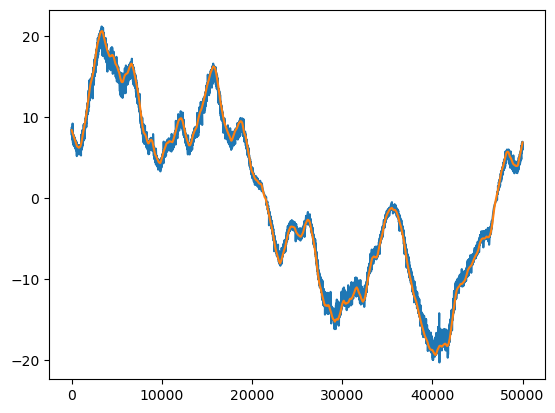

In [39]:
estimate.shape
plt.plot(estimate.T)
plt.plot(stimulus)

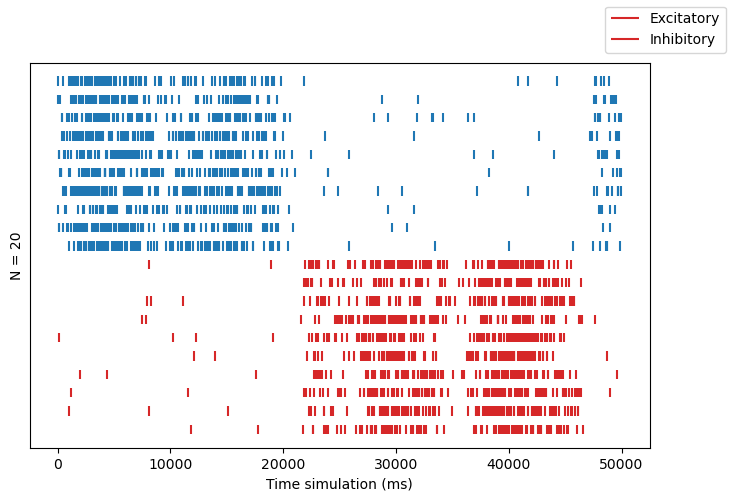

In [60]:
fig = plt.figure(figsize = (8,5))
axs = fig.add_subplot()

total_num_spikes = 0
for n in range(20): # params['N']
    if D[:, n] > 0:
        color = 'C0'
    else:
        color = 'tab:red'
    axs.eventplot(spike_idx_neurons[n], lineoffset = n+1, linelength = 0.5, colors = color)
axs.set_ylim([0,params['N']+1]) # params['N']
axs.set(xlabel = 'Time simulation (dt)', ylabel = 'N = {}'.format(params['N']), yticks = [])
# axs.xaxis.set_major_formatter(fig.FuncFormatter(set_ms)) # covert points to ms
# axs.annotate('{} = {} ms'.format(parameter, param_values[1]*0.05), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1) # uncomment when plotting time delays
# ax2.annotate('{} = {}'.format(parameter, param_values[1]), (0.05, 0.85), xycoords = 'axes fraction', backgroundcolor='1',alpha=1)
# labels = [axs.Line2D([0], [0], color='C0', label = '$+$ weight'), plt.Line2D([0], [0], color = 'C3', label = '$-$ weight')]
# fig.legend(handles = labels, loc = 'upper center', bbox_to_anchor = (0.5, 1.0),  ncol = len(param_values))
